# Lecture Week 11 Assignment: llama-2-7B-nsmc

1. Fine-tuning [llama-2-7b-chat-hf](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf) for understanding order sentences

- First 9,000 samples from the NSMC train split (for training)
- First 1,000 samples from the NSMC test split (for validation)

Dependencies required
- Setting up a Hugging Face account and obtaining authorization to use llama-2
- wandb for logging

2. Objective

When movie review texts are included in the prompt and input into the model, <br/>
it directly generates the prediction text as 'positive' or 'negative'. <br/>

In [ ]:
pip install transformers peft accelerate optimum bitsandbytes trl wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import os
from dataclasses import dataclass, field
from typing import Optional
import re

import torch
import tyro
from accelerate import Accelerator
from datasets import load_dataset, Dataset
from peft import AutoPeftModelForCausalLM, LoraConfig
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)

from trl import SFTTrainer

from trl.trainer import ConstantLengthDataset

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

After mounting the drive, upload files:
- food-order-understanding-small-3200.json
- food-order-understanding-small-800.json

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# /gdrive/MyDrive/Lectures/2023/nlp/food-order-understanding-small-3200.json
# /gdrive/MyDrive/Lectures/2023/nlp/food-order-understanding-small-800.json

# Setting parameters

In [ ]:
@dataclass
class ScriptArguments:
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "the cache dir"}
    )
    model_name: Optional[str] = field(
        default="meta-llama/Llama-2-7b-chat-hf", metadata={"help": "the model name"}
    )

    dataset_name: Optional[str] = field(
        default=None,
        metadata={"help": "the dataset name"},
    )
    seq_length: Optional[int] = field(
        default=1024, metadata={"help": "the sequence length"}
    )
    num_workers: Optional[int] = field(
        default=8, metadata={"help": "the number of workers"}
    )
    training_args: TrainingArguments = field(
        default_factory=lambda: TrainingArguments(
            output_dir="./results",
            # max_steps=500,
            logging_steps=20,
            # save_steps=10,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=2,
            gradient_checkpointing=False,
            group_by_length=False,
            learning_rate=1e-4,
            lr_scheduler_type="cosine",
            # warmup_steps=100,
            warmup_ratio=0.03,
            max_grad_norm=0.3,
            weight_decay=0.05,
            save_total_limit=20,
            save_strategy="epoch",
            num_train_epochs=1,
            optim="paged_adamw_32bit",
            fp16=True,
            remove_unused_columns=False,
            report_to="wandb",
        )
    )

    packing: Optional[bool] = field(
        default=True, metadata={"help": "whether to use packing for SFTTrainer"}
    )

    peft_config: LoraConfig = field(
        default_factory=lambda: LoraConfig(
            r=8,
            lora_alpha=16,
            lora_dropout=0.05,
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "down_proj", "up_proj", "gate_proj"],
            bias="none",
            task_type="CAUSAL_LM",
        )
    )

    merge_with_final_checkpoint: Optional[bool] = field(
        default=False, metadata={"help": "Do only merge with final checkpoint"}
    )

 **ScriptArguments class** <br/>
 Provide a simpler way to create classes that are primarily used to store data, similar to a record or a struct in other programming languages <br/>
  **Attributes**: <br/>
Each attribute in the class represents a parameter that can be passed to a script or a function, potentially to configure the behavior of a machine learning model or a training process. These attributes include settings like cache directory, model name, dataset name, sequence length, number of workers, and various training arguments<br/>
**Type Hints**: <br/>
The Optional type hint is used to indicate that an attribute can be of a specified type or None. This is useful for parameters that are not mandatory. For example, cache_dir: Optional[str] = None means cache_dir can be a string specifying a path to a cache directory or None if no directory is specified <br/>
**Default Values**: <br/>
Attributes are given default values using the field() function from the dataclasses module, which also allows for the specification of metadata. For example, default=None sets the default value of cache_dir to None, and metadata={"help": "the cache dir"} provides a description of what the cache_dir attribute is used for <br/>
**TrainingArguments**: <br/>
The training_args attribute is an instance of a TrainingArguments class (presumably defined elsewhere), configured with various training-related parameters such as output directory, logging steps, batch sizes, learning rate, and others. This class seems to be tailored for configuring the training process of a machine learning model<br/>
**Packing**: <br/>
The packing attribute is a boolean flag that indicates whether to use packing for SFTTrainer, which is likely a specific technique or optimization in the training process <br/>
**PeftConfig**: <br/>
The peft_config attribute is an instance of the LoraConfig class (presumably defined elsewhere), which is configured with parameters for LoRA (Low-Rank Adaptation), a technique used to adapt pre-trained models to new tasks with minimal extra parameters <br/>
**MergeWithFinalCheckpoint**: <br/>
The merge_with_final_checkpoint attribute is a boolean flag indicating whether to only merge with the final checkpoint during some aspect of the model's training or adaptation process <br/>

# Utility

In [ ]:
def chars_token_ratio(dataset, tokenizer, nb_examples=400):
    """
    Estimate the average number of characters per token in the dataset.
    """
    total_characters, total_tokens = 0, 0
    for _, example in tqdm(zip(range(nb_examples), iter(dataset)), total=nb_examples):
        text = prepare_sample_text(example)
        total_characters += len(text)
        if tokenizer.is_fast:
            total_tokens += len(tokenizer(text).tokens())
        else:
            total_tokens += len(tokenizer.tokenize(text))

    return total_characters / total_tokens


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Both functions analyze and report characteristics of datasets and machine learning models <br/>
**chars_token_ratio Function** <br/>
Estimates the average number of characters per token in a dataset<br/>
Particularly useful in natural language processing (NLP) to understand the granularity of tokenization performed by a tokenizer <br/>
-Example: <br/>
First sentence: "Hello, world!" <br/>
Tokens would be ["Hello,", "world!"] <br/>
Number of characters in "Hello," = 6 <br/>
Number of characters in "world!" = 6 <br/>
Total characters = 12 <br/>
Number of tokens = 2 <br/>
Characters per token for this sentence = 12 / 2 = 6 <br/>
-Parameters: <br/>
dataset: <br/>
The dataset to be analyzed. It's expected to be an iterable of examples <br/>
tokenizer: <br/>
A tokenizer object used to tokenize the text. This object should have methods like tokenize for tokenizing the text and possibly is_fast to check if the tokenizer implements a fast tokenization method <br/>
nb_examples: <br/>
The number of examples from the dataset to use for the estimation. Defaults to 400 <br/>
Process: <br/>
Iterates over nb_examples from the dataset <br/>
Example: <br/>
Prepares the text using a function prepare_sample_text (not shown in the code snippet), which likely formats or extracts text from the dataset example <br/>
It calculates the total number of characters and tokens for these examples <br/>
If the tokenizer is a fast tokenizer (tokenizer.is_fast is True), it uses tokenizer(text).tokens() to get the token list and counts them. Otherwise, it uses tokenizer.tokenize(text) to tokenize the text and counts the tokens.
Output: The function returns the average number of characters per token by dividing the total number of characters by the total number of tokens <br/>

**print_trainable_parameters Function** <br/>
Prints the number of trainable parameters in a given model, which is critical for understanding the complexity and capacity of machine learning models <br/>
-Parameter: <br/>
model: <br/>
Model whose parameters are to be analyzed. This model should have a method named_parameters() that returns an iterator over all parameters of the model, with each parameter being a tuple containing the name of the parameter and the parameter itself <br/>
Process: <br/>
Iterates over all parameters of the model <br/>
Counts the total number of parameters (all_param) and the number of trainable parameters (trainable_params). A parameter is considered trainable if param.requires_grad is True <br/>
Calculates the percentage of parameters that are trainable <br/>
-Output: <br/>
Prints the total number of trainable parameters, the total number of parameters, and the percentage of parameters that are trainable <br/>
Both functions serve as useful utilities for analyzing datasets and models in the context of machine learning and NLP, providing insights into the efficiency of tokenization and model complexity <br/>








# Data Loading

In [ ]:
def prepare_sample_text(example):
    """Prepare the text from a sample of the dataset."""

    prompt_template = """###System;{System}
    ###User;{User}
    ###Midm;{Midm}"""

    default_system_msg = (
        "너는 먼저 사용자가 작성한 영화 리뷰의 감정을 분석하는 에이전트이다. 이로부터 긍정 또는 부정을 판단해야 한다."
    )

    text = (
        prompt_template.format(System=default_system_msg, User=example["document"],Midm="긍정" if example["label"]==1 else "부정")
    )

    return text

**Function prepare_sample_text** <br/>
This function is about formatting the dataset <br/>
It takes individual samples from the dataset and formats them into a structured text format according to a predefined template <br/>
This process is often necessary in data preparation phases of machine learning projects, especially in natural language processing (NLP) tasks, where the input data needs to be in a specific format for the models to process effectively <br/>
prompt_template: <br/>
A string template that outlines the format in which the text should be prepared. It includes placeholders for text from the system ({System}), the user ({User}), and a middle part ({Midm}) that seems to be intended for a brief message or status (e.g., "긍정" for positive or "부정" for negative sentiment) <br/>
default_system_msg: <br/>
Variable holds a default message in Korean, which translates to "You are an agent that first analyzes the sentiment of a movie review written by a user. From this, you must determine whether it is positive or negative." This message is used to populate the {System} part of the prompt_template <br/>
Formatting the text: The function formats the text by filling in the prompt_template with the default_system_msg, the user's document from example["document"], and a sentiment indication ("긍정" for positive or "부정" for negative) based on the example["label"] value <br/>
The sentiment is determined by checking if the label is 1 (assumed to indicate a positive sentiment) or otherwise (assumed to indicate a negative sentiment) <br/>
**Example Funtion Usage** <br/>
Example Input <br/>
```
example = {
    "document": "이 영화 정말 재미있어요!",
    "label": 1
}
```
Example Output <br/>
```
###System;너는 먼저 사용자가 작성한 영화 리뷰의 감정을 분석하는 에이전트이다. 이로부터 긍정 또는 부정을 판단해야 한다.
###User;이 영화 정말 재미있어요!
###Midm;긍정
```


In [ ]:
def create_datasets(tokenizer, args):
    data = load_dataset(args.dataset_name, cache_dir=args.cache_dir)
    train_data = data['train'].select(range(9000))

    chars_per_token = chars_token_ratio(train_data, tokenizer)
    print(f"The character to token ratio of the dataset is: {chars_per_token:.2f}")

    train_dataset = ConstantLengthDataset(
        tokenizer,
        train_data,
        formatting_func=prepare_sample_text,
        infinite=True,
        seq_length=args.seq_length,
        chars_per_token=chars_per_token,
    )
    return train_dataset

**create_datasets**: <br/>
Designed to prepare a dataset for training a machine learning model, specifically within the context of natural language processing (NLP) <br/>
Involves loading a dataset, estimating the character-to-token ratio for the training data, and then initializing a training dataset with a constant sequence length <br/>
-Function Parameters: <br/>
tokenizer: <br/>
A tokenizer object used to convert text into tokens (or words into numerical representations). This is a common preprocessing step in NLP <br/>
args: <br/>
An object or structure (likely a class instance) that contains various settings and configurations, such as the dataset name and cache directory <br/>
-Process Overview: <br/>
**Load the dataset**: <br/>
The function begins by loading a dataset using the load_dataset function, with the dataset name and cache directory specified in args <br/>
The load_dataset function is commonly used in NLP for fetching datasets from a repository or local storage <br/>
**Select training data**: <br/>
From the loaded dataset, it selects a subset (in this case, the first 9000 samples) from the training portion (data['train']) to use as training data. This subset selection might be done to limit the amount of data for efficiency or computational reasons <br/>
**Estimate character-to-token ratio** <br/>
Calculates the average number of characters per token in the training data using the previously discussed chars_token_ratio function. This metric can be important for understanding the granularity of the tokenization and for configuring sequence lengths in models that process the data <br/>
**Print the character-to-token ratio**: <br/>
Displays the calculated ratio, providing insight into the dataset's tokenization characteristics <br/>
**Initialize a ConstantLengthDataset**: <br/>
Creates an instance of ConstantLengthDataset with several parameters: <br/>
tokenizer: <br/>
The tokenizer object <br/>
train_data: <br/>
The selected training data <br/>
formatting_func: <br/>
A function to format the data samples, presumably prepare_sample_text from an earlier discussion. This function structures each sample in a consistent way before tokenization <br/>
infinite: <br/>
A boolean indicating whether the dataset should infinitely loop over the data. This can be useful in training regimes where the number of epochs is defined by the number of steps rather than complete passes over the dataset <br/>
seq_length: <br/>
The desired sequence length for samples in the dataset, taken from args seq_length. This is important for models like Transformers, which require inputs to be of a consistent size <br/>
chars_per_token: <br/>
The calculated character-to-token ratio. This may influence how the ConstantLengthDataset prepares data, possibly affecting how sequences are padded or truncated to maintain a constant length <br/>
Return the training dataset: <br/>
Finally, the function returns the train_dataset object, which is now ready to be used for training a model <br/>
This function encapsulates several critical steps in data preparation for NLP tasks, ensuring that the training data is properly loaded, formatted, and ready for use with a model that expects input sequences of a fixed length <br/>








In [ ]:
def create_valid_datasets(tokenizer, args):
    dataset = load_dataset(args.dataset_name, cache_dir=args.cache_dir)
    valid_data = dataset['test']
    valid_dataset = valid_data.select(range(1000))

    return valid_dataset

**Function create_valid_datasets** <br/>
Designed to prepare a validation dataset from a larger dataset collection for the purpose of evaluating a machine learning model, particularly in the context of natural language processing (NLP) <br/>
-Parameters: <br/>
tokenizer: <br/>
This is a tokenizer object, used typically in NLP tasks to convert strings of text into numerical tokens that a model can understand <br/>
However, it is not used <br/>
args: <br/>
An object or class instance that contains configuration options <br/>
In this case, args.dataset_name specifies the name of the dataset to load, and args.cache_dir specifies the directory to cache the dataset, reducing load times in future access <br/>
-Process Overview: <br/>
**Load the dataset**: <br/>
The function starts by loading a dataset using the load_dataset function, provided with args.dataset_name for the dataset's name and args.cache_dir for caching. This dataset is expected to have multiple splits (such as train, validation, test) <br/>
**Select the validation (or test) data**: <br/>
It accesses the 'test' split of the dataset via dataset['test']. In many datasets, the 'test' split is used as a stand-in for validation data, especially if a dedicated validation split is not provided <br/>
**Create a subset of the validation data**: <br/>
The function then creates a subset of this validation (or test) data by selecting the first 1000 examples <br/>
This is done through the select(range(1000)) method. This step is likely intended to limit the amount of data used during validation to speed up the evaluation process or to fit within resource constraints <br/>
**Return the validation dataset**: <br/>
Finally, the function returns the valid_dataset, which is now a smaller, manageable subset of the original 'test' split of the dataset. This subset is ready to be used for model evaluation or validation purposes <br/>
**Summary**: <br/>
This function streamlines the process of preparing a validation dataset from a larger, potentially unwieldy dataset <br/>
By selecting a fixed number of examples (in this case, 1000), it ensures that the evaluation process is both manageable and reproducible <br/>
The lack of use of the tokenizer parameter in this function suggests that tokenization might be handled elsewhere, possibly during the actual evaluation or in a separate data preprocessing step <br/>








# Loading model for fine-tuning

In [ ]:
script_args = ScriptArguments(
    num_workers=2,
    seq_length=512,
    dataset_name='nsmc',
    model_name='meta-llama/Llama-2-7b-chat-hf',
    )

**ScriptArguments class** <br/>
Creating an instance of the ScriptArguments class with specific settings, presumably to configure a script or software application that involves data processing, model training, or inference <br/>
Argument passed to ScriptArguments means: <br/>
num_workers=2: <br/>
Specifies the number of worker threads or processes to use <br/>
In the context of data loading or processing, using multiple workers can speed up tasks that are I/O bound or can be parallelized, such as loading data from disk or preprocessing data <br/>
seq_length=512: <br/>
This indicates the sequence length, which is a critical parameter in many natural language processing (NLP) tasks, especially those involving models like Transformers. A sequence length of 512 means that inputs will be truncated or padded to ensure they are 512 tokens long. This length is a trade-off between computational efficiency and the capacity to handle longer texts <br/>
dataset_name='nsmc': <br/>
The name of the dataset to be used <br/>
"nsmc" stands for Naver Movie Corpus, a popular dataset for Korean sentiment analysis <br/>
It contains movie reviews in Korean, along with labels indicating whether the sentiment of the review is positive or negative <br/>
model_name='meta-llama/Llama-2-7b-chat-hf': <br/>
This identifies the specific model to be used or loaded <br/>
'meta-llama/Llama-2-7b-chat-hf': <br/>
Refers to a version of the LLaMA (Large Language Model) by Meta, hosted on Hugging Face's Model Hub (hf stands for Hugging Face) <br/>
2-7b: <br/>
This model has around 2.7 billion parameters, making it a large and powerful language model capable of understanding and generating human-like text. The "chat" part implies it's optimized or intended for chat or conversational applications <br/>
Summary: <br/>
Instance of ScriptArguments is configured for a task that involves using the NSMC dataset with a sequence length of 512 tokens, processed or analyzed by the "meta-llama/Llama-2-7b-chat-hf" model, utilizing 2 worker threads for data loading or processing activities <br/>
This configuration could be used for tasks such as fine-tuning the specified model on the NSMC dataset for sentiment analysis or generating responses in a chat application <br/>
Given these settings, the script is likely set up to fine-tune the Meta-LLaMA model on the NSMC dataset to improve or adapt its performance for sentiment analysis of Korean movie reviews. Fine-tuning involves continuing the training of a pre-trained model on a specific task or dataset, which in this case is to predict the sentiment of movie reviews accurately <br/>





In [ ]:
script_args.training_args.logging_steps = 100
script_args.training_args.max_steps = 200
script_args.training_args.output_dir = '/gdrive/MyDrive/nlp/lora-llama-2-7b-movie-review-understanding'
script_args.training_args.run_name = 'llama-2-7b-movie-review-understanding'

**Setting Training Arguments** <br/>
**Adjusting training_args**: <br/>
After initializing script_args, specific training parameters are set through the training_args attribute <br/>
These settings likely influence the behavior of the training process <br/>
**logging_steps = 100**: <br/>
Configures the training to log progress (such as loss, evaluation metrics, etc.) every 100 steps <br/>
This helps in monitoring the training progress over time <br/>
**max_steps = 200**: <br/>
Limits the training process to a total of 200 steps. This can be useful for quick experiments or when computational resources are limited <br/>
**output_dir = '/gdrive/MyDrive/nlp/lora-llama-2-7b-movie-review-understanding'**: <br/>
Specifies the directory where training outputs (like model checkpoints and logs) will be saved. <br/>
**run_name = 'llama-2-7b-movie-review-understanding':**  <br/>
Sets a name for the training run, which can help in identifying and organizing experiments, especially when tracking training runs using external tools <br/>
Overall, this setup configures a training session for fine-tuning a specific pre-trained model on the NSMC dataset, with parameters tailored for performance monitoring, computational efficiency, and organization of training outputs <br/>


In [ ]:
print(script_args)

ScriptArguments(cache_dir=None, model_name='meta-llama/Llama-2-7b-chat-hf', dataset_name='nsmc', seq_length=512, num_workers=2, training_args=TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

**bnb_config snippet**: <br/>
A configuration setup for using the BitsAndBytes library with PyTorch models, specifically geared towards optimizing model memory usage and possibly compute efficiency <br/>
-BitsAndBytes: <br/>
A library that enhances the efficiency of training deep neural networks by implementing advanced techniques such as mixed precision training and custom optimizer implementations <br/>
Breakdown of each configuration option in the snippet: <br/>
-load_in_4bit: <br/>
Enables loading the model weights in 4-bit precision <br/>
This is an aggressive quantization technique that significantly reduces the memory footprint of the model weights at the cost of some precision <br/>
This can be particularly useful for deploying large models on hardware with limited memory resources or for speeding up inference by reducing the amount of data that needs to be moved around <br/>
bnb_4bit_quant_type: <br/>
-nf4 value: <br/>
Specifies the type of 4-bit quantization to use. Different quantization schemes can offer trade-offs between precision, performance, and compatibility with various hardware accelerators <br/>
-bnb_4bit_compute_dtype: <br/>
This setting specifies the data type to use for computations when the model is quantized to 4-bit. torch.bfloat16 is chosen here, which stands for Brain Floating Point Format with 16 bits. bfloat16 is a floating-point format that offers a wide dynamic range with just 16 bits of precision, making it suitable for deep learning applications where the exact precision of weights and activations is less important than the ability to represent very large or very small numbers. Using bfloat16 for compute can speed up operations on hardware that supports it, while still benefiting from the memory savings of 4-bit quantization for storage <br/>
Together, these settings configure a model to use a very memory-efficient representation while still attempting to maintain computational efficiency and model accuracy <br/>
This setup is particularly useful for working with very large models or when deploying models to environments where memory is a critical constraint. However, it's important to experiment and evaluate the impact of these settings on your specific model and task, as quantization can affect model accuracy and performance <br/>

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    script_args.model_name,
    quantization_config=bnb_config,
    device_map="auto",  # {"": Accelerator().local_process_index},
    trust_remote_code=True,
    use_auth_token=True,
    cache_dir=script_args.cache_dir,
)
base_model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Creating a model that is designed for **causal language modeling (CLM)** <br/>
-Use the transformers library from Hugging Face <br/>
-Causal language modeling is a task where the model predicts the next token in a sequence given the previous tokens, which is useful for tasks like text generation <br/>
-AutoModelForCausalLM.from_pretrained: <br/>
This method loads a pre-trained model specified by script_args.model_name. The AutoModelForCausalLM class automatically detects the model architecture from the name or path provided and initializes the model accordingly. This makes it easy to load different models without having to change your code <br/>
script_args.model_name: <br/>
This is the name of the pre-trained model you want to load.
Example": "gpt-2" or any other model that's designed for causal language modeling and available in Hugging Face's model hub <br/>
-quantization_config = bnb_config: <br/>
Quantization is a technique to reduce the memory footprint of the model by reducing the precision of the weights <br/>
bnb_config likely refers to a configuration for BitFit quantization provided by bitsandbytes library, which is integrated into Hugging Face Transformers for certain operations. This can make model loading and inference faster and less memory-intensive <br/>
-device_map="auto": <br/>
This option automatically maps the model's layers to the available devices (like different GPUs or CPUs) to optimize inference or training. The commented-out part # {"": Accelerator().local_process_index} suggests an alternative way to map models to devices, likely using Hugging Face's Accelerate library for distributed training <br/>
-trust_remote_code=True: <br/>
By setting this to True, you allow the model to load and execute custom code that might come with the model. This is useful for models that have custom components, but it should be used with caution as it poses a security risk if the source is not trusted <br/>
-use_auth_token=True: <br/>
Indicates that an authentication token (such as from Hugging Face's huggingface.co) should be used when downloading the model. This is necessary for accessing models that are private or require authentication <br/>
-cache_dir=script_args.cache_dir: <br/>
Specifies the directory where the model should be cached. Useful for avoiding repeated downloads of the same model <br/>
-After loading the model, the line base_model.config.use_cache = False is used to modify the model's configuration to not use caching during the generation. Caching is often used to speed up generation by storing previous computations, but disabling it can be useful in certain scenarios, such as when generating very long sequences where caching could lead to excessive memory usage <br/>
-In summary, this code snippet is for loading a pre-trained causal language model with specific configurations for device mapping, quantization, and caching, possibly in a distributed or resource-optimized setting <br/>

In [ ]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

In [ ]:
peft_config = script_args.peft_config

Taking a configuration setting (peft_config) from an object that contains script arguments or parameters (script_args) and assigns it to a new variable for easy access within the script <br/>

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=8, target_modules={'down_proj', 'o_proj', 'v_proj', 'up_proj', 'q_proj', 'gate_proj', 'k_proj'}, lora_alpha=16, lora_dropout=0.05, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    script_args.model_name,
    trust_remote_code=True,
    cache_dir=script_args.cache_dir,
)

if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training

base_model.config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Preparing a tokenizer for use in a machine learning model, specifically for tasks that may involve text generation or processing <br/>
**(1)Tokenizer Initialization** <br/>
AutoTokenizer.from_pretrained(script_args.model_name, trust_remote_code=True, cache_dir=script_args.cache_dir,): <br/>
-AutoTokenizer.from_pretrained <br/>
Method that loads a tokenizer associated with a given pre-trained model <br/> Tokenizers are used to convert text into a format that the model can understand (e.g., converting sentences into token IDs).
-script_args.model_name: <br/>
Name of the pre-trained model for which the tokenizer is being loaded <br/>
-trust_remote_code=True <br/>
Allows the loading of custom tokenizer code from the internet <br/>
This is necessary if the tokenizer includes custom processing, but it can pose security risks if you're not sure about the source <br/>
cache_dir=script_args.cache_dir <br/>
Specifies the directory where the tokenizer should be cached, which helps avoid downloading the tokenizer again in future runs <br/>
**(2)Padding Token Setup** <br/>
if getattr(tokenizer, "pad_token", None) is None: <br/>
Checks if the tokenizer has a padding token set (pad_token) <br/>
The getattr function tries to retrieve pad_token from the tokenizer, and if it's not found, it returns None <br/>
Padding tokens are used to make all sequences in a batch the same length for batch processing. If a sequence is shorter than others in the batch, padding tokens are added to it <br/>
tokenizer.pad_token = tokenizer.eos_token: <br/>
If the tokenizer does not have a padding token set, this line sets the padding token (pad_token) to be the same as the end-of-sequence token (eos_token) <br/>
This is common in models like GPT where the same token is used for both padding and indicating the end of a sequence <br/>
**(3)Padding Configuration** <br/>
tokenizer.padding_side = "right": <br/>
Configures the tokenizer to add padding tokens to the right (end) of the sequences. This is a standard setting for many NLP models, though some tasks or models may require left-side padding <br/>
The comment mentions fixing a "weird overflow issue with fp16 training." Training models in fp16 (16-bit floating-point) can lead to various numerical issues due to the reduced precision. This setting helps mitigate one such issue related to sequence padding <br/>
**(4)Linking Tokenizer and Model Configuration** <br/>
base_model.config.pad_token_id = tokenizer.pad_token_id: <br/>
Sets the pad_token_id in the model's configuration (base_model.config) to match the pad_token_id of the tokenizer. This ensures that the model knows which token ID to treat as padding during training or inference.
This step is crucial for models that need to be aware of padding, especially for tasks involving sequence generation, classification, or any other scenario where sequence length varies.
In summary, this code snippet is about setting up a tokenizer for use with a pre-trained model, ensuring it correctly handles padding for sequences of varying lengths. It also includes a step to avoid potential issues related to training in reduced precision (fp16). This setup is essential for preparing data for processing with machine learning models, particularly in natural language processing tasks.

In [ ]:
training_args = script_args.training_args

In [ ]:
train_dataset = create_datasets(tokenizer, script_args)
valid_dataset = create_valid_datasets(tokenizer, script_args)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

100%|██████████| 400/400 [00:00<00:00, 3036.70it/s]
/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:548: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


The character to token ratio of the dataset is: 0.84


Create the training and validation datasets <br/>
By passing a tokenizer and script_args object to them <br/>
-The script_args object likely contains necessary parameters like dataset_name and cache_dir, similar to those accessed within the functions <br/>
-These datasets are then used to train and validate a machine learning model, allowing for the experimentation with different subsets of data and training/validation strategies <br/>

In [ ]:
len(train_dataset)

9000

In [ ]:
len(valid_dataset)

1000

In [ ]:
trainer = SFTTrainer(
    model=base_model,
    train_dataset=train_dataset,
    eval_dataset=None,
    peft_config=peft_config,
    packing=script_args.packing,
    max_seq_length=script_args.seq_length,
    tokenizer=tokenizer,
    args=training_args,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:267: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


**SFTTrainer** <br/>
https://huggingface.co/docs/trl/sft_trainer<br/>
Supervised fine-tuning (or SFT for short) is a crucial step in RLHF. In TRL we provide an easy-to-use API to create your SFT models and train them with few lines of code on your dataset <br/>
-model: <br/>
Receives base_model, which is the model that will be trained <br/>
The base_model represents the neural network architecture that will be used for the task at hand <br/>
-train_dataset: <br/>
The dataset on which the model will be trained <br/>
The train_dataset is expected to be a dataset object that contains the training data, including inputs and possibly their corresponding labels <br/>
-eval_dataset: <br/>
Set to None, indicating that no separate dataset is being provided for evaluation during training. Typically, an evaluation dataset is used to monitor the model's performance on a separate set of data that it hasn't seen during training, helping to gauge its generalization capability <br/>
peft_config: <br/>
A configuration related to the Pretrained Encoder Fine-Tuning (PEFT) process or a similar training strategy <br/>
packing: <br/>
Set to script_args.packing, suggesting that whether or how input data should be packed (grouped or batched) is controlled by an argument passed to the script. Packing can affect training efficiency and performance, especially for sequence models <br/>
max_seq_length: <br/>
The maximum sequence length for the inputs is set to script_args.seq_length This defines the length to which inputs will be truncated or padded, ensuring consistent input sizes for models that require them, such as transformers <br/>
tokenizer: <br/>
The tokenizer used to preprocess text data into a format suitable for the model. Tokenizers convert strings into numerical representations that neural networks can work with, typically by converting words or characters into tokens or token IDs <br/>
args: This is set to training_args, providing additional arguments or configurations for training. While not specified in this snippet, training_args could include a variety of training parameters such as the number of epochs, learning rate, batch size, and others <br/>

In [ ]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
   

In [ ]:
print_trainable_parameters(base_model)

trainable params: 19988480 || all params: 3520401408 || trainable%: 0.5677897967708119


**print_trainable_parameters(base_model)** <br/>
Summary of the parameters in the base_model <br/>
parameters: Values that the model learns from the training data <br/> Understanding the number and type of parameters in a model can be crucial for several reasons, including insights into the model's potential capacity to learn, its complexity, and computational demands <br/>
**trainable params: 19988480**: <br/>
The model has 19,988,480 parameters that can be updated during the training process <br/>
Trainable parameters are those that the training algorithm adjusts through backpropagation. The model's ability to learn from data is directly related to these parameters <br/>
all params: 3520401408: <br/>
This shows that the total number of parameters in the model, both trainable and non-trainable, is 3,520,401,408 <br/>
Non-trainable parameters are not updated during training; they can include parameters that are kept constant during training, such as those transferred from a pre-trained model during transfer learning <br/>
trainable%: 0.5677897967708119: <br/>
This percentage represents the proportion of trainable parameters relative to the total number of parameters in the model, calculated as (trainable params / all params) * 100 <br/>
The given percentage, approximately 0.568%, is very low, suggesting that a very small fraction of the model's parameters are being trained. This could be typical for scenarios involving transfer learning, where the majority of a pre-existing model's parameters are frozen to retain learned features, and only a small portion is fine-tuned for a specific task <br/>


Google Colab T-4 GPU: Estimated Time 1:37:34 <br/>
-A total of 1,600 steps needed <br/>
-However, it ends earlier, at less than 900 steps <br/>
For a sequence length of 512 <br/>
14.4 G / 15.0 G used <br/>
Reduce from 512 if memory overflow occurs <br/>

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,0.856100
200,0.661100


TrainOutput(global_step=200, training_loss=0.7585945129394531, metrics={'train_runtime': 176.3809, 'train_samples_per_second': 2.268, 'train_steps_per_second': 1.134, 'total_flos': 8143665679564800.0, 'train_loss': 0.7585945129394531, 'epoch': 0.04})

trainer.train(): <br/>
Initiates the training process using the configuration provided to the SFTTrainer instance <br/>
The model will learn from train_dataset according to the specifications in peft_config, training_args, and other parameters <br/>

In [ ]:
script_args.training_args.output_dir

'/gdrive/MyDrive/nlp/lora-llama-2-7b-movie-review-understanding'

**script_args.training_args.output_dir**: <br/>
References the output_dir attribute of the training_args field within a ScriptArguments instance <br/>
This would be the directory where training outputs, such as model checkpoints and logs, are saved <br/>

In [ ]:
trainer.save_model(script_args.training_args.output_dir)

Calls the save_model method on an object named trainer <br/>
The model is saved to a directory specified by script_args.training_args.output_dir <br/>


# Inference Test

In [ ]:
from transformers import pipeline, TextStreamer

**pipeline** <br/>
Great and easy way to use models for inference <br/>
These pipelines are objects that abstract most of the complex code from the library, offering a simple API dedicated to several tasks <br/>
Including Named Entity Recognition, Masked Language Modeling, Sentiment Analysis, Feature Extraction and Question Answering. See the task summary for examples of use <br/>
**TextStreamer** <br/>
Ref: https://huggingface.co/docs/transformers/v4.39.1/en/internal/generation_utils#transformers.TextStreamer <br/>

In [ ]:
instruction_prompt_template = """###System;다음은 네이버 영화 리뷰들을 모아놓은 문장이다. 이를 분석하여 사용자가 작성한 영화 리뷰의 감정을 긍정 또는 부정으로 예측하라.

### 리뷰 내용: {0} ### 분석 결과:
"""

prompt_template = """###System;{System}
###User;{User}
###Midm;"""

default_system_msg = (
        "너는 먼저 사용자가 작성한 영화 리뷰의 감정을 분석하는 에이전트이다. 이로부터 긍정 또는 부정을 판단해야 한다."
)

Templates for constructing prompts in a conversational AI or natural language processing context, particularly focusing on sentiment analysis of movie reviews <br/>
Designed for an interactive system, possibly a chatbot or an AI model that processes natural language inputs <br/>

In [ ]:
def wrapper_generate(model, input_prompt):
    data = tokenizer(input_prompt, return_tensors="pt")
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    input_ids = data.input_ids[..., :-1]
    with torch.no_grad():
        pred = model.generate(
            input_ids=input_ids.cuda(),
            streamer=streamer,
            use_cache=True,
            max_new_tokens=float('inf'),
            temperature=0.5
        )
    decoded_text = tokenizer.batch_decode(pred, skip_special_tokens=True)
    return (decoded_text[0][len(input_prompt):])

wrapper_generate: <br/>
Designed to generate text using a pre-trained model and a tokenizer <br/>
This function takes an input prompt and processes it through a model to generate a continuation of the prompt <br/>
**parameters**: <br/>
model: The pre-trained model used for generating text <br/>
input_prompt: Text input that the model will use as a basis for generating new text <br/>
**Tokenizing the Input** <br/>
The input_prompt is tokenized using a tokenizer <br/>
The return_tensors="pt" argument specifies that the output will be PyTorch tensors <br/>
This step converts the input text into a format that the model can understand (e.g., a sequence of token IDs) <br/>
**Initializing TextStreamer** <br/>
TextStreamer is designed to handle streaming of text for generation purposes. The arguments suggest it's configured to skip the initial prompt and special tokens in its operations, focusing on generating only new text <br/>
**Preparing Input IDs** <br/>
Extracts the input IDs from the tokenized data and removes the last token <br/>
This adjustment might be necessary based on the specific requirements of how the model generates text, possibly to exclude an end-of-sequence token or similar <br/>
**Generating Text** <br/>
-Generation is performed within a torch.no_grad() context to disable gradient calculations, reducing memory consumption and speeding up the process since gradients are not needed for inference <br/>
-The model.generate function is called with the prepared input_ids, which are moved to a GPU (.cuda()) <br/>
The custom streamer is also passed in, along with other generation settings:
use_cache: Likely optimizes generation by caching previous computations.
max_new_tokens: Set to infinity (float('inf')), suggesting no limit on the length of the generated text. This is unusual and might be a placeholder or indicative of a custom handling mechanism within streamer or elsewhere <br/>
temperature: Controls the randomness of the output. A value of 0.5 makes the gen <br/>
**Decoding the Generated Tokens** <br/>
The generated predictions (pred) are decoded back into text, skipping special tokens (like padding or end-of-sequence tokens) for cleaner output <br/>

In [ ]:
eval_dic1 = {i:wrapper_generate(model=base_model, input_prompt=prompt_template.format(System=default_system_msg, User=query["document"]))for i, query in enumerate(valid_dataset)}

;부정
;긍정
;부정
;부정
;부정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정


A Python dictionary comprehension that is creating a dictionary, eval_dic1 <br/>
-Each key is an index(i) and each value is the result of calling the wrapper_generate function with a specific model and input_prompt <br/>
The input_prompt is formatted using the prompt_template string, filled with a System message and a User query from valid_dataset <br/>

In [ ]:
print(eval_dic1[0])

부정


# Test after loading fine-tuned model

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

Configuring an instance of BitsAndBytesConfig, likely a configuration object for the BitsAndBytes library or a similar mechanism within a larger system that supports model optimization through quantization and datatype adjustments <br/>
**BitsAndBytesConfig** <br/>
BitsAndBytesConfig is a class that holds configuration settings for model quantization and optimization <br/>
Quantization is a technique used to reduce the precision of the numbers used to represent model weights, from floating-point numbers to integers or lower-precision floats, which can significantly reduce the model size and speed up inference while attempting to maintain accuracy <br/>
Configuration Options <br/>
load_in_4bit=True: This setting indicates that the model weights should be loaded or represented using 4-bit precision <br/>
Typical floating-point representations are 32 bits, so moving to 4-bit greatly reduces the memory footprint. This can be particularly beneficial for deploying models on devices with limited resources or for applications where inference speed is critical <br/>
bnb_4bit_quant_type="nf4": <br/>
Specifies the type of quantization to be used <br/>
Generally, quantization types can vary in how they map floating-point numbers to lower-precision representations, affecting the balance between performance, accuracy, and memory usage <br/>
bnb_4bit_compute_dtype=torch.bfloat16 <br/>
This setting specifies the datatype to be used for computations when the model is quantized to 4-bit <br/>
torch.bfloat16 is a 16-bit floating point representation that offers wider dynamic range than 16-bit integer representations, making it suitable for machine learning computations where precision is less critical than in other floating-point computations but more critical than in pure integer computations <br/>
Using bfloat16 can lead to performance improvements on hardware that supports it, as it requires less memory bandwidth and allows for faster computations than full 32-bit precision <br/>
Overall, this configuration is setting up a system for quantizing a model to use 4-bit weights for storage, possibly converting them to bfloat16 for computation to balance the trade-offs between model size, computational speed, and accuracy. This kind of optimization is particularly relevant in contexts where resources are constrained or when deploying large models that need to operate efficiently in real-time applications <br/>

In [ ]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    script_args.training_args.output_dir,
    quantization_config=bnb_config,
    device_map="auto",
    cache_dir=script_args.cache_dir
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating an instance of a pre-trained model, presumably for a causal language modeling (LM) task <br/>
-With support for parameter-efficient fine-tuning (PEFT) and quantization optimization <br/>
-The AutoPeftModelForCausalLM class is likely part of a machine learning framework designed for NLP tasks, and the method from_pretrained is used to load a pre-trained model from a specified directory with additional configurations for deployment or further training <br/>



In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    script_args.model_name,
    trust_remote_code=True,
    cache_dir=script_args.cache_dir,
)

if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training
trained_model.config.pad_token_id = tokenizer.pad_token_id

**Tokenizer Initialization** <br/>
Setting up a tokenizer for a machine learning model, specifically within the context of natural language processing (NLP) tasks using the Hugging Face transformers library <br/>
The code is doing several things to prepare the tokenizer and align it with the model's requirements <br/>
-AutoTokenizer.from_pretrained: <br/>
Method is used to initialize a tokenizer object from a pre-trained model specified by script_args.model_name <br/>
The AutoTokenizer class automatically detects the appropriate tokenizer class based on the name or path of the pre-trained model <br/>
-script_args.model_name: <br/>
Contains the name or path of the pre-trained model for which the tokenizer is to be loaded. It's likely specified by the user or a configuration file.
trust_remote_code=True: <br/>
The code is willing to run custom code from the server hosting the model (if any exists). This is necessary for some models that come with custom tokenization logic <br/>
cache_dir=script_args.cache_dir: <br/>
Specifies the directory where the tokenizer files should be cached. This is useful for avoiding repeated downloads of the tokenizer files in future runs <br/>
**Setting the Pad Token** <br/>
Checks if the tokenizer has a padding token (pad_token) set <br/>
If not (None), it assigns the end-of-sequence token (eos_token) as the padding token <br/>
Padding tokens are used to make all sequences in a batch the same length for batch processing <br/>
The end-of-sequence token marks the end of a text sequence and can serve as a padding token when no other is specified <br/>
**Adjusting Padding Behavior** <br/>
The code explicitly sets the tokenizer to pad sequences on the right (i.e., add padding tokens to the end of sequences) <br/>
This adjustment is noted to fix an unspecified "weird overflow issue with fp16 training," suggesting that the model training uses 16-bit floating-point precision (fp16), which can be more sensitive to certain data formatting issues <br/>
**Aligning Model Configuration with Tokenizer** <br/>
-Finally, this line ensures that the model's configuration is aware of the correct padding token ID used by the tokenizer <br/>
The pad_token_id is the numerical ID that represents the padding token in tokenized sequences <br/>
It's important for the model to know this ID for tasks involving sequence processing, as it might need to ignore padding tokens during computations or loss calculation <br/>
A typical setup process for ensuring that the tokenizer is correctly configured for use with a specific pre-trained model, especially addressing potential issues related to padding and precision in training <br/>








During the inference process, about 5.5 GB of GPU memory is utilized <br/>

In [ ]:
valid_dataset = create_valid_datasets(tokenizer, script_args)

Calling the function **create_valid_datasets** with two arguments:
tokenizer and script_args <br/>


In [ ]:
eval_dic2 = {i:wrapper_generate(model=trained_model, input_prompt=prompt_template.format(System=default_system_msg, User=query["document"]))for i, query in enumerate(valid_dataset)}

;긍정
;긍정
;부정
;부정
;부정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;부정
;부정
;부정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;긍정
;부정
;부정
;부정
;긍정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;긍정
;부정
;부정
;긍정
;긍정
;부정
;부정
;부정
;긍정
;긍정
;부정
;긍정
;긍정
;긍정
;긍정
;긍정


Creating a dictionary named eval_dic2 using a dictionary comprehension <br/>
It iterates over valid_dataset, a collection of data, used for evaluation <br/>
Each element in this dataset is referred to as query, and the iteration also keeps track of the index of each element with i <br/>
For each element, it performs a specific operation involving a function call to wrapper_generate <br/>
**Dictionary Comprehension**: <br/>
The expression {i: wrapper_generate(...) for i, query in enumerate(valid_dataset)} is a dictionary comprehension <br/>
It is a concise way to create a dictionary from an iterable (in this case, valid_dataset) <br/>
Each item in valid_dataset is enumerated, which means it is provided with an index (i) starting from 0, and the item itself is referred to as query <br/>
**Enumerate Function**: <br/>
The enumerate(valid_dataset) part is a built-in function that takes an iterable (here, valid_dataset) and returns it as an enumerate object <br/>
This object generates pairs containing each element and its corresponding index <br/>
**wrapper_generate Function Call**: <br/>
For each element in the dataset, the code calls a function named wrapper_generate with two keyword arguments <br/>
model=trained_model: <br/>
Use a pre-defined model <br/>
trained_model is a variable holding the model.
input_prompt=prompt_template.format(...) <br/>
Constructs an input prompt by formatting a string (prompt_template) with .format(System=default_system_msg, User=query["document"]) <br/>
This formatting replaces placeholders in prompt_template with values <br/>
default_system_msg is used for a placeholder named System, and query["document"] is used for a placeholder named User <br/>
Meaning that prompt_template is a string with placeholders like {System} and {User}, which are dynamically filled with the respective values <br/>
The Key-Value Pair in the Dictionary: <br/>
Each key in the resulting dictionary (eval_dic2) is the index of the query (i), and the corresponding value is the result of the wrapper_generate function call <br/>
The result likely depends on the implementation of wrapper_generate but could involve generating a response or prediction based on the input_prompt and the trained_model <br/>
**Purpose**: <br/>
The overall purpose of this code snippet seems to be to apply a model to generate outputs for each item in valid_dataset <br/>
The outputs are stored in a dictionary where each key corresponds to the index of the item in the dataset, making it easy to reference the outputs later <br/>
Commonly used in machine learning and natural language processing (NLP) tasks, where you need to generate predictions or responses for a set of inputs and possibly compare them to expected outcomes for evaluation purposes <br/>

In [ ]:
print(eval_dic2[0])

긍정


# Classification results for test data

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_models_performance(true_labels, predicted_labels):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    # Visualize confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
    plt.show()


Function **evaluate_models_performance** that evaluates the performance of classification models <br/>
By calculating and visualizing several key metrics: <br/>
confusion matrix, accuracy, precision, and recall <br/>
**Import Statements**: <br/>
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score: <br/>
Imports necessary functions from sklearn.metrics to compute confusion matrix, accuracy, precision, and recall <br/>
import seaborn as sns: <br/>
Imports the seaborn library for visualizing the confusion matrix <br/>
import matplotlib.pyplot as plt: <br/>
Imports the matplotlib library for plotting <br/>
**Function Definition**: <br/>
evaluate_models_performance(true_labels, predicted_labels) defines a function that takes two parameters <br/>
true_labels: <br/>
The actual labels of the data <br/>
predicted_labels: <br/>
The labels predicted by the classification model <br/>
Calculate Metrics: <br/>
confusion_matrix(true_labels, predicted_labels): <br/>
Computes the confusion matrix using the true and predicted labels <br/>
The confusion matrix is a table that is often used to describe the performance of a classification model, with each row representing the instances in an actual class and each column representing the instances in a predicted class <br/>
**Accuracy** <br/>
accuracy_score(true_labels, predicted_labels): <br/>
Calculates the accuracy of the model, which is the proportion of correctly predicted observations to the total observations <br/>
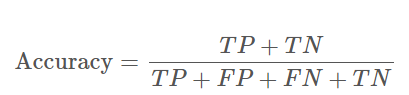 <br/>
**Precision** <br/>
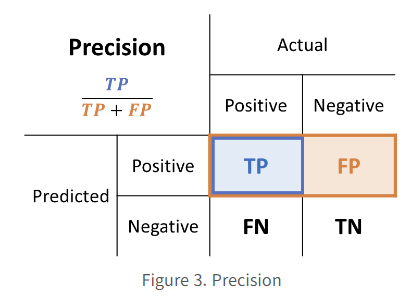 <br/>
precision_score(true_labels, predicted_labels): <br/>
Computes the precision of the model, which is the proportion of correctly predicted positive observations to the total predicted positive observations <br/>
Precision indicates how accurate the results detected as Positive are<br/>
**Recall** <br/>
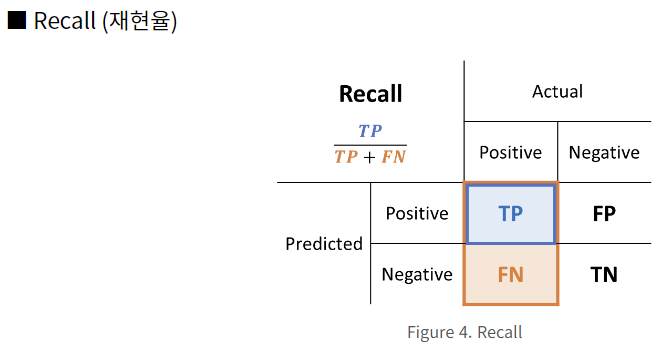 <br/>
recall_score(true_labels, predicted_labels): <br/>
Calculates the recall (or sensitivity) of the model, which is the proportion of correctly predicted positive observations to all the observations in actual class. <br/>
**Visualize Confusion Matrix**: <br/>
The seaborn heatmap (sns.heatmap) is used to visualize the confusion matrix. The parameters include:
cm: The confusion matrix data.
annot=True: Annotates the heatmap with the data values (counts).
fmt="d": Formats the annotated data as integers.
cmap="Blues": Uses a blue color palette.
xticklabels and yticklabels: Sets the labels for the x-axis and y-axis, respectively, to "Negative" and "Positive".
Labels for the x-axis and y-axis are set using plt.xlabel("Predicted Label") and plt.ylabel("True Label"), respectively.
The title of the plot includes the calculated accuracy, precision, and recall, formatted to two decimal places.
Display Plot: plt.show() displays the plot. This visual representation helps in understanding the model's performance in terms of how many predictions are true positives, true negatives, false positives, and false negatives, along with the calculated accuracy, precision, and recall metrics <br/>
This function is a comprehensive tool for evaluating and visualizing the performance of binary classification models, providing valuable insights into their effectiveness <br/>
Ref: <br/>
https://ai-com.tistory.com/entry/ML-%EB%B6%84%EB%A5%98-%EC%84%B1%EB%8A%A5-%EC%A7%80%ED%91%9C-Precision%EC%A0%95%EB%B0%80%EB%8F%84-Recall%EC%9E%AC%ED%98%84%EC%9C%A8 <br/>


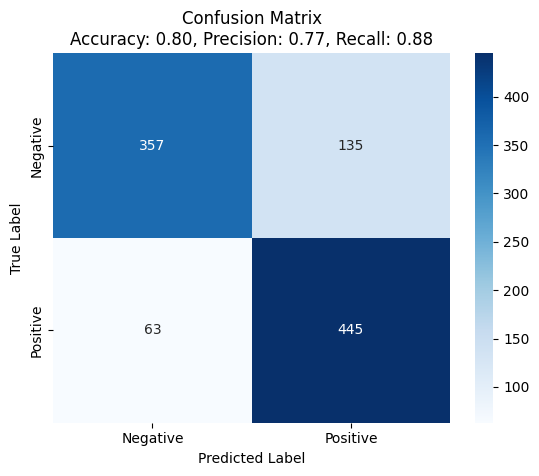

In [ ]:
# PEFT Model Performance
true_labels = [example["label"] for example in valid_dataset]
predicted_labels = [1 if "긍정" in eval_dic2[i] else 0 for i in range(len(valid_dataset))]
evaluate_models_performance(true_labels, predicted_labels)

Evaluating the performance of a model, presumably named "PEFT", using a validation dataset (valid_dataset) and a set of predictions stored in a dictionary (eval_dic2) <br/>
The process involves generating true and predicted labels from the data, and then using these labels to evaluate the model's performance through a previously defined function, evaluate_models_performance <br/>
**Generating True Labels**: <br/>
true_labels = [example["label"] for example in valid_dataset] <br/>
Creates a list of true labels by iterating over each example in valid_dataset <br/>
For each example, it extracts the "label" value, which represents the true classification of each example (e.g., Positive or Negative) <br/>
**Generating Predicted Labels**: <br/>
predicted_labels = [1 if "긍정" in eval_dic2[i] else 0 for i in range(len(valid_dataset))] <br/>
Creates a list of predicted labels <br/>
Iterates over the indices of valid_dataset (from 0 to the length of valid_dataset minus one) <br/>
For each index i, it checks if the string "긍정" (which means "Positive" in Korean) is present in the value associated with the key i in eval_dic2, a dictionary containing the model's predictions <br/>
If "긍정" is found in the prediction for an example, the model predicted that example as Positive (1), otherwise, it is considered Negative (0) <br/>
**Evaluating Model Performance**: <br/>
evaluate_models_performance(true_labels, predicted_labels): <br/>
Calls the evaluate_models_performance function, passing in the true_labels and predicted_labels lists as arguments <br/>
This function calculates performance metrics such as accuracy, precision, and recall, and visualizes the confusion matrix using these labels <br/>
The evaluation will provide insights into how well the PEFT model performs, specifically, how accurate its positive predictions are (precision), among other metrics <br/>
In summary, this code is used to evaluate the performance of the PEFT model by comparing its predictions (encoded as presence or absence of the term "긍정" in eval_dic2) against the true labels from the validation dataset <br/>
The evaluation focuses on key metrics that reveal the model's effectiveness in classifying examples correctly <br/>

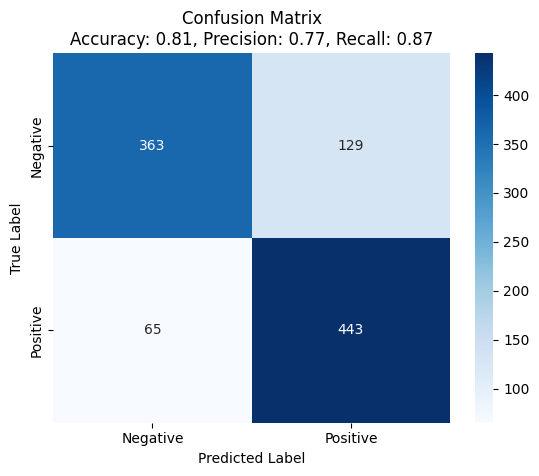

In [ ]:
# Base Model Performance
true_labels = [example["label"] for example in valid_dataset]
predicted_labels = [1 if "긍정" in eval_dic1[i] else 0 for i in range(len(valid_dataset))]
evaluate_models_performance(true_labels, predicted_labels)

Evaluating the performance of a different model, here referred to as the "Base Model," using the same validation dataset (valid_dataset) <br/>
Key difference lies in the source of the predicted labels, which in this case comes from eval_dic1 instead of eval_dic2 <br/>
**Generating True Labels**: <br/>
true_labels = [example["label"] for example in valid_dataset] <br/>
Iterates over valid_dataset, a collection of examples, and extracts the true classification label ("label") from each example <br/>
These labels are the ground truth against which the model's predictions are compared <br/>
**Generating Predicted Labels**:
predicted_labels = [1 if "긍정" in eval_dic1[i] else 0 for i in range(len(valid_dataset))] <br/>
Generates a list of predicted labels based on the contents of eval_dic1, which contains the predictions made by the Base Model <br/>
For each index i corresponding to an example in the validation dataset, the code checks if the string "긍정" (meaning "Positive" in Korean) is present in the prediction stored in eval_dic1[i] <br/>
If "긍정" is found, the example is labeled as Positive (1); otherwise, it is labeled as Negative (0) <br/>
This binary labeling reflects the model's prediction on whether each example is Positive or Negative <br/>
**Evaluating Model Performance**: <br/>
evaluate_models_performance(true_labels, predicted_labels) <br/>
This function call evaluates the performance of the Base Model by comparing the predicted labels with the true labels <br/>
The evaluate_models_performance function, calculates key performance metrics such as accuracy, precision, and recall, and visualizes the confusion matrix <br/>
These metrics offer insights into the model's ability to accurately classify examples and specifically how well it identifies Positive cases <br/>
The code evaluates and visualizes the performance of the Base Model by using a set of true labels from a validation dataset and a set of predicted labels derived from the model's predictions (as stored in eval_dic1) <br/>
The evaluation focuses on understanding the model's effectiveness and reliability in classification tasks, with a specific interest in its precision (i.e., the accuracy of its Positive predictions) <br/>

**Peft Model Results** <br/>
Accuracy:0.80 <br/>
Model correctly predicted 80% of the cases. This is a good overall measure of the model's effectiveness.<br/>
Precision: 0.77 <br/>
High precision, meaning 77.0% of the predicted positive cases are actually positive<br/>
Recall: 0.88 <br/>
The model is able to capture 88% of all actual positive instances<br/>

#Upload the fine-tuned adapter to Hugging Face Hub & include the uploaded ID in the notebook

https://huggingface.co/growingpenguin/hw-llama-2-7B-nsmc/tree/main/lora-llama-2-7b-movie-review-understanding